Training Predictor Shape:  (214200, 33, 2)
Training Predictee Shape:  (214200, 1)
Test Predictor Shape:  (214200, 33, 2)
Modeling Stage




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 33, 16)            1216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 7,52

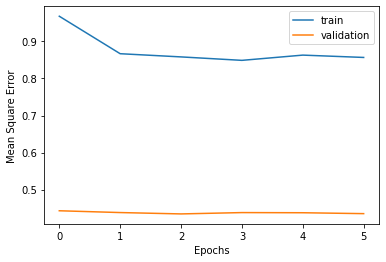

\Output Submission
   item_cnt_month
0        0.578887
1        0.118937
2        0.911624
3        0.183084
4        0.118937

Model Runtime: 27.09 Minutes
Notebook Runtime: 28.10 Minutes


<Figure size 432x288 with 0 Axes>

In [6]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import gc

# Viz
import matplotlib.pyplot as plt

# Import data
sales = pd.read_csv('../Data/sales_train.csv', parse_dates=['date'], infer_datetime_format=True, dayfirst=True)
shops = pd.read_csv('../Data/shops.csv')
items = pd.read_csv('../Data/items.csv')
cats = pd.read_csv('../Data/item_categories.csv')
val = pd.read_csv('../Data/test.csv')

# Rearrange the raw data to be monthly sales by item-shop
df = sales.groupby([sales.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).sum().reset_index()
df = df[['date','item_id','shop_id','item_cnt_day']]
df["item_cnt_day"].clip(0.,20.,inplace=True)
df = df.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()

# Merge data from monthly sales to specific item-shops in test data
test = pd.merge(val,df,on=['item_id','shop_id'], how='left').fillna(0)

# Strip categorical data so keras only sees raw timeseries
test = test.drop(labels=['ID','item_id','shop_id'],axis=1)

# Rearrange the raw data to be monthly average price by item-shop
# Scale Price
scaler = MinMaxScaler(feature_range=(0, 1))
sales["item_price"] = scaler.fit_transform(sales["item_price"].values.reshape(-1,1))
df2 = sales.groupby([sales.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).mean().reset_index()
df2 = df2[['date','item_id','shop_id','item_price']].pivot_table(index=['item_id','shop_id'], columns='date',values='item_price',fill_value=0).reset_index()

# Merge data from average prices to specific item-shops in test data
price = pd.merge(val,df2,on=['item_id','shop_id'], how='left').fillna(0)
price = price.drop(labels=['ID','item_id','shop_id'],axis=1)

# Create x and y training sets from oldest data points
y_train = test['2015-10']
x_sales = test.drop(labels=['2015-10'],axis=1)
x_sales = x_sales.values.reshape((x_sales.shape[0], x_sales.shape[1], 1))
x_prices = price.drop(labels=['2015-10'],axis=1)
x_prices= x_prices.values.reshape((x_prices.shape[0], x_prices.shape[1], 1))
X = np.append(x_sales,x_prices,axis=2)

y = y_train.values.reshape((214200, 1))
print("Training Predictor Shape: ",X.shape)
print("Training Predictee Shape: ",y.shape)
del y_train, x_sales; gc.collect()

# Transform test set into numpy matrix
test = test.drop(labels=['2013-01'],axis=1)
x_test_sales = test.values.reshape((test.shape[0], test.shape[1], 1))
x_test_prices = price.drop(labels=['2013-01'],axis=1)
x_test_prices = x_test_prices.values.reshape((x_test_prices.shape[0], x_test_prices.shape[1], 1))

# Combine Price and Sales Df
test = np.append(x_test_sales,x_test_prices,axis=2)
del x_test_sales,x_test_prices, price; gc.collect()
print("Test Predictor Shape: ",test.shape)

print("Modeling Stage")
# Define the model layers
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X.shape[1], X.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

# Train Model
print("\nFit Model")
VALID = True
LSTM_PARAM = {"batch_size":128,
              "verbose":2,
              "epochs":10}

modelstart = time.time()
if VALID is True:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=1, shuffle=False)
    # del X,y; gc.collect()
    print("X Train Shape: ",X_train.shape)
    print("X Valid Shape: ",X_valid.shape)
    print("y Train Shape: ",y_train.shape)
    print("y Valid Shape: ",y_valid.shape)
    
    callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]
    hist = model_lstm.fit(X_train, y_train,
                          validation_data=(X_valid, y_valid),
                          callbacks=callbacks_list,
                          **LSTM_PARAM)
    pred = model_lstm.predict(test)

    # Model Evaluation
    best = np.argmin(hist.history["val_loss"])
    print("Optimal Epoch: {}",best)
    print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Square Error")
    plt.legend()
    plt.show()
    plt.savefig("Train and Validation MSE Progression.png")

if VALID is False:
    print("X Shape: ",X.shape)
    print("y Shape: ",y.shape)
    hist = model_lstm.fit(X,y,**LSTM_PARAM)
    pred = model_lstm.predict(X)
    
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Square Error")
    plt.legend()
    plt.show()
    plt.savefig("Training Loss Progression.png")

print("\Output Submission")
submission = pd.DataFrame(pred,columns=['item_cnt_month'])
submission.to_csv('submission.csv',index_label='ID')
print(submission.head())
print("\nModel Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))
